In [ ]:
# api token upload
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shifamehreen","key":"8b94ce850d6d49c566ad1e21d062cd71"}'}

In [ ]:
# load dataset form kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


In [ ]:
df = pd.read_csv("/content/full_df.csv")
df.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
5699,3412,70,Female,3412_left.jpg,3412_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3412_left.jpg
2317,3203,74,Female,3203_left.jpg,3203_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3203_right.jpg
1292,1820,65,Male,1820_left.jpg,1820_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration,0,0,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",1820_right.jpg
5082,2743,55,Male,2743_left.jpg,2743_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2743_left.jpg
4261,1306,72,Male,1306_left.jpg,1306_right.jpg,glaucoma,glaucoma,0,0,1,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",1306_left.jpg


In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(cataract),len(normal))

594 500


In [ ]:
from keras_preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset


In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [00:02<00:00, 247.03it/s]


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:01<00:00, 253.74it/s]


In [ ]:
len(dataset)

1088

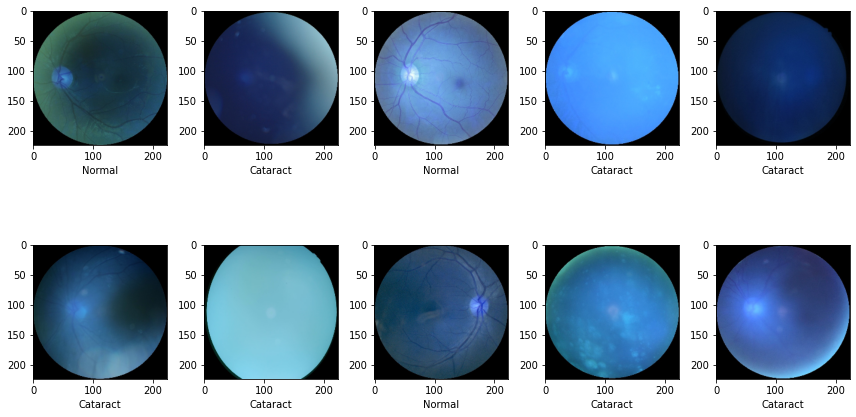

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.8977

28/28 [==============================] - 23s 329ms/step - loss: 1.4384 - accuracy: 0.8977 - val_loss: 1.0554 - val_accuracy: 0.9083
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.9575

28/28 [==============================] - 6s 207ms/step - loss: 0.3549 - accuracy: 0.9575 - val_loss: 0.5664 - val_accuracy: 0.9450
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9759

28/28 [==============================] - 6s 208ms/step - loss: 0.1213 - accuracy: 0.9759 - val_loss: 0.5686 - val_accuracy: 0.9587
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9908

28/28 [==============================] - 6s 209ms/step - loss: 0.0322 - accuracy: 0.9908 - val_loss: 0.5834 - val_accuracy: 0.9495
Epoch 5/15
28/28 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9977

28/28 [==============================] - 6s 210ms/step - loss: 0.0091 - accuracy: 0.9977 - val_loss: 0.4893 - val_accuracy: 0.9633
Epoch 6/15
28/28 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9828

28/28 [==============================] - 6s 216ms/step - loss: 0.0861 - accuracy: 0.9828 - val_loss: 0.5484 - val_accuracy: 0.9633
Epoch 7/15
28/28 [==============================] - ETA: 0s - loss: 0.0231 - accuracy: 0.9931

28/28 [==============================] - 6s 212ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.4718 - val_accuracy: 0.9633
Epoch 8/15
28/28 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9989

28/28 [==============================] - 6s 214ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.4967 - val_accuracy: 0.9541
Epoch 9/15
28/28 [==============================] - ETA: 0s - loss: 7.1603e-04 - accuracy: 1.0000

28/28 [==============================] - 6s 215ms/step - loss: 7.1603e-04 - accuracy: 1.0000 - val_loss: 0.6506 - val_accuracy: 0.9495
Epoch 10/15
28/28 [==============================] - ETA: 0s - loss: 1.1123e-04 - accuracy: 1.0000

28/28 [==============================] - 6s 217ms/step - loss: 1.1123e-04 - accuracy: 1.0000 - val_loss: 0.6070 - val_accuracy: 0.9541
Epoch 11/15
28/28 [==============================] - ETA: 0s - loss: 1.9933e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 217ms/step - loss: 1.9933e-05 - accuracy: 1.0000 - val_loss: 0.6020 - val_accuracy: 0.9541
Epoch 12/15
28/28 [==============================] - ETA: 0s - loss: 1.6409e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 219ms/step - loss: 1.6409e-05 - accuracy: 1.0000 - val_loss: 0.6027 - val_accuracy: 0.9541
Epoch 13/15
28/28 [==============================] - ETA: 0s - loss: 1.4920e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 221ms/step - loss: 1.4920e-05 - accuracy: 1.0000 - val_loss: 0.6068 - val_accuracy: 0.9541
Epoch 14/15
28/28 [==============================] - ETA: 0s - loss: 1.3178e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 222ms/step - loss: 1.3178e-05 - accuracy: 1.0000 - val_loss: 0.6058 - val_accuracy: 0.9541
Epoch 15/15
28/28 [==============================] - ETA: 0s - loss: 1.2058e-05 - accuracy: 1.0000

28/28 [==============================] - 6s 224ms/step - loss: 1.2058e-05 - accuracy: 1.0000 - val_loss: 0.6067 - val_accuracy: 0.9541


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 173ms/step - loss: 0.6067 - accuracy: 0.9541
loss: 0.6067376136779785
Accuracy: 0.9541284441947937


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")


7/7 [==============================] - 1s 171ms/step


In [ ]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

In [ ]:
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 83,   8],
       [  2, 125]], dtype=int32)>

Text(33.0, 0.5, 'Actual')

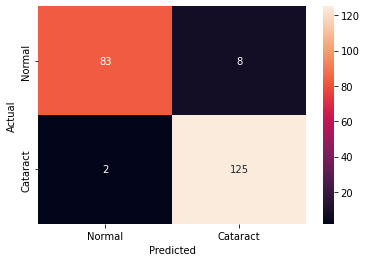

In [ ]:
import seaborn as sns
x_labels = ["Normal", "Cataract"]
y_labels = ["Normal", "Cataract"]
sns.heatmap(cm, annot=True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
accuracy_score(y_test,y_pred)

0.9541284403669725

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        91
           1       0.94      0.98      0.96       127

    accuracy                           0.95       218
   macro avg       0.96      0.95      0.95       218
weighted avg       0.96      0.95      0.95       218



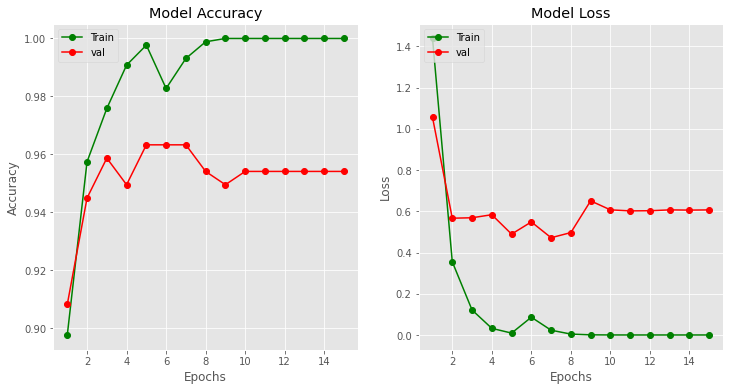

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()


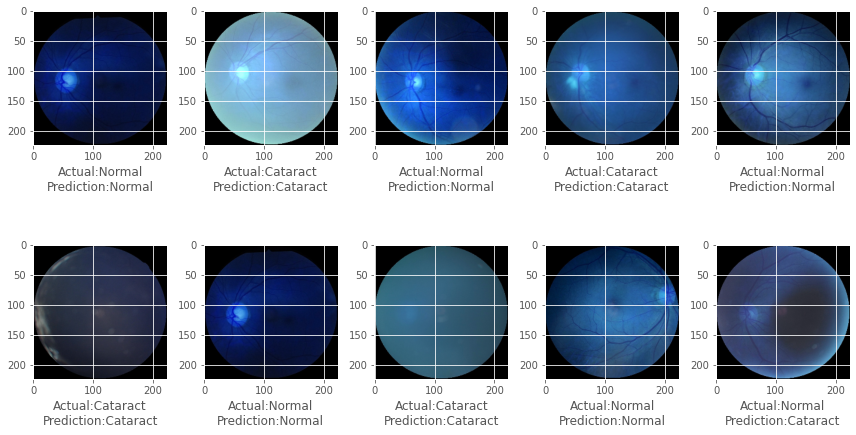

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()